\author{Brice Robert} 

***Student:*** Brice Robert, ***Track:*** ICS

***Document:*** REPORT.pdf, ***Type:*** Laboratory

***Languages used:*** LaTeX, Julia (in lieu of MATLAB)

***Tools used:*** Jupyter, nbconvert (converting to PDF)

***Permanent Link:*** https://github.com/setrar/MobCom/blob/main/Lab/REPORT.ipynb

| MATLAB PROJECT for MOBCOM |
|:-:|
| EURECOM |
| November 21st, 2024 |
| Class Instructor: Petros Elia |
| elia@eurecom.fr |

- Read carefully the following questions, and using MATLAB, provide the answers/plots in the form of a report.
- The report should include a title page, and should be properly labeled and named. The report should be in the form of a PDF.
- Graphs should include labels, titles, and captions.
- Each graph should be accompanied with pertinent comments.
- Use optimal (maximum likelihood) decoders, unless stated otherwise.
- To compare the empirical results with the corresponding theoretical result, you should superimpose the two corresponding graphs and provide comments and intuition on the comparison.
- For each plot, describe the theoretical background that guides the proper choice of parameters for simulations (i.e., power constraint).
- You can work in groups of two or three.


- Regarding Grading:
    - All questions are weighted equally.
    - Submit your report (labeled and named) via email, to Hui Zhao (Hui.Zhao@eurecom.fr) and to myself.
    - Submission deadline is December 12th, 2024.




Enjoy!






---
**$$\text{PROBLEM 2}$$**


- **Use simulations to establish the probability of deep fade**  

$$
P(\|h\|^2 < \text{SNR}^{-1})
$$

for the random fading model:

$$
y = h \cdot x + w
$$

where $w \sim \mathbb{C}N(0, 1)$, and where $h$ is a Rician random variable, where you can choose the parameters of this distribution.

- **Now do the same when $h$ is now a 3-length vector with i.i.d. Rician elements.**

In all the above, the y-axis is the probability of deep fade, in log scale ($\log_{10}(\text{Prob})$), and the x-axis is the SNR, in dB.

---

Step-by-step implementation in `Julia`, including simulations for both a single `Rician fading coefficient` and a `3-length vector` of i.i.d. Rician fading elements.

# **Mathematical Model**

- The random fading model is:
  $y = h \cdot x + w,$
  where:
  - $h$: Rician fading random variable.
  - $x$: Transmitted signal (can be any constant since it’s irrelevant for this computation).
  - $w \sim \mathbb{C}N(0, 1)$: Complex Gaussian noise.

- Deep fade probability:
  $P(\|h\|^2 < \text{SNR}^{-1}),$
  where:
  - $\|h\|^2$ is the power of the fading channel.
  - $\text{SNR} = 10^{\text{SNR}_{\text{dB}} / 10}$.

For a 3-length vector of i.i.d. Rician fading elements:
$\|h\|^2 = \sum_{i=1}^3 |h_i|^2,$
where $h_i$ are i.i.d. Rician variables.

# **Simulation Steps**



Import Required Libraries

In [1]:
using Random
using Distributions
using LinearAlgebra
using Plots, LaTeXStrings, Measures 
using FFTW

In [2]:
# functions and variables to increase readability
include("modules/operations.jl");

In [3]:
# Define base values and offsets
base_values = [-0.00, -0.50, -1.00, -1.50, -2.00]
offsets = [-0.0, -0.02, -0.10, -0.15, -0.20, -0.30, -0.40, -0.70]
include("modules/view_helper.jl");

#### **Step 1: Generate Rician Fading Coefficients**
A Rician fading random variable $h$ is parameterized by:
- $K$: The Rician $K$-factor (ratio of LOS to NLOS power).
- $\sigma$: The standard deviation of the NLOS component.

The Rician fading can be generated as:
$h = v + z,$
where:
- $v$: Deterministic LOS component ($v = \sqrt{K / (K+1)}$).
- $z \sim \mathbb{C}N(0, \sigma^2 / 2)$: Complex Gaussian NLOS component.


In [4]:
# Generate Rician fading
function generate_rician(n, K, σ)
    ν = sqrt(K / (K + 1))  # LOS component
    σ_r = σ / sqrt(2 * (K + 1))  # NLOS component
    real = rand(Normal(ν, σ_r), n)
    imag = rand(Normal(0, σ_r), n)
    return real .+ j .* imag  # Complex Rician fading
end;

#### **Step 2: Compute $\|h\|^2$**
For the single random variable $h$:

In [5]:
# Compute magnitude squared for single Rician variable
function compute_magnitude_squared(h)
    return abs2.(h)  # Compute |h|^2 for all samples
end;

For the 3-length vector:

In [6]:
# Compute magnitude squared for a 3-length Rician vector
function compute_vector_magnitude_squared(h_vector::Matrix{ComplexF64})
    return sum(abs2, h_vector, dims=1)  # Sum squared magnitudes along rows
end;

#### **Step 3: Compute Probability of Deep Fade**
Evaluate the probability:
$P(\|h\|^2 < \text{SNR}^{-1})$
for a range of SNR values.

In [7]:
# Compute deep fade probability
function deep_fade_probability(h, SNR_range)
    probabilities = Float64[]
    for SNR_dB in SNR_range
        SNR_linear = 10^(SNR_dB / 10)  # Convert dB to linear scale
        threshold = 1 / SNR_linear
        fade_count = count(x -> x < threshold, compute_magnitude_squared(h))
        push!(probabilities, fade_count / length(h))
    end
    return probabilities
end

# Compute deep fade probability for vector
function deep_fade_probability_vector(h_vector, SNR_range)
    probabilities = Float64[]
    for SNR_dB in SNR_range
        SNR_linear = 10^(SNR_dB / 10)  # Convert dB to linear scale
        threshold = 1 / SNR_linear
        fade_count = count(x -> x < threshold
            , compute_vector_magnitude_squared(h_vector)
        )
        # Use second dimension for vectors
        push!(probabilities, fade_count / size(h_vector, 2))  
    end
    return probabilities
end;

#### **Step 4: Perform Monte Carlo Simulation**
Simulate $h$ for both cases.

In [8]:
# Parameters
n_samples = 10^6  # Number of samples
K = 2  # Rician K-factor
σ = 1.0  # Standard deviation
SNR_dB_range = 0:3:30  # SNR range in dB

# Single Rician random variable
h = generate_rician(n_samples, K, σ)
prob_single = deep_fade_probability(h, SNR_dB_range)

# 3-length Rician vector
h_vector = reshape(
            reduce(vcat
                  # Generate 3 independent Rician variables
                , [generate_rician(n_samples, K, σ) for _ in 1:3])  
            , (3, :)
        ) # Reshape to (3, n_samples)
prob_vector = deep_fade_probability_vector(h_vector, SNR_dB_range);

#### **Step 5: Plot the Results**
Plot the deep fade probabilities on a logarithmic scale ($\log_{10}(\text{Prob})$).



In [9]:
println("Single Rician Variable (log): ", log10.(prob_single))
println("3-Length Rician Vector (log): ", log10.(prob_vector))

Single Rician Variable (log): [-0.23255915208786465, -0.5371948547366029, -0.8818973790242725, -1.2249213694702286, -1.5545514857339502, -1.87014904921109, -2.1767214430483293, -2.476643793345207, -2.7833064008302455, -3.087246696328677, -3.4111682744057927]
3-Length Rician Vector (log): [-1.526586026739016, -2.5316526695878427, -3.562249437179612, -4.481486060122113, -5.221848749616356, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf]


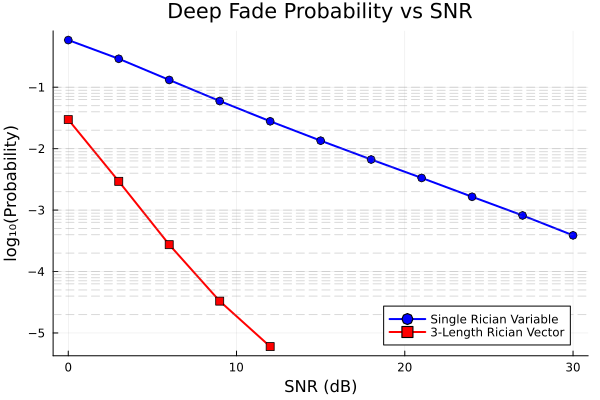

In [10]:
# Plot results with labels, title, and grid in the first plot call
plot(SNR_dB_range, log10.(prob_single)
    , label="Single Rician Variable", marker=:o, lw=2, color=:blue
    , xlabel="SNR (dB)", ylabel="log₁₀(Probability)"
    , title="Deep Fade Probability vs SNR"
    , grid=true, legend = :bottomright)
plot!(SNR_dB_range, log10.(prob_vector)
    , label="3-Length Rician Vector", marker=:square, lw=2, color=:red)
add_combined_hlines!(offsets, base_values
    , linestyle=:dash, lw=1, color=:gray, alpha=0.3)

# **Expected Results**
1. **Single Rician Variable:**
   - At low SNR, the deep fade probability is high ($\log_{10}(P) \approx 0$).
   - At high SNR, the probability drops exponentially ($\log_{10}(P) < -6$).

2. **3-Length Rician Vector:**
   - The deep fade probability is lower than for a single variable due to the diversity gain.
   - The curve decreases faster with increasing SNR compared to the single variable case.